In [1]:
import os
import shutil
import random
from pathlib import Path
from glob import glob
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import HeNormal
import json
import cv2
from tqdm import tqdm


# This is critical if you also want to run PyTorch in the same Kaggle session.
try:
    gpus = tf.config.list_physical_devices('GPU')
    for _gpu in gpus:
        tf.config.experimental.set_memory_growth(_gpu, True)
except Exception as _e:
    # Safe to ignore if devices are already initialized
    print(f"WARNING: could not set TF memory growth: {_e}")

# For Inception V1 (PyTorch)
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
TORCH_AVAILABLE = True


DATASET_NAME = "minc2500/minc-2500" 

# Kaggle paths
KAGGLE_INPUT = f"/kaggle/input/{DATASET_NAME}"
KAGGLE_WORKING = "/kaggle/working"
IMAGES_DIR   = os.path.join(DATASET_NAME, "images")
LABELS_DIR   = os.path.join(DATASET_NAME, "labels")
# Check if running on Kaggle
IS_KAGGLE = os.path.exists('/kaggle/input')
NEEDS_SPLIT = False

if IS_KAGGLE:
    print("Running on Kaggle!")
    # Auto-detect dataset structure
    print("Detecting dataset structure...")
    
    # Check for pre-split structure (train/val/test folders)
    if os.path.exists(os.path.join(KAGGLE_INPUT, "train")):
        OUTPUT_DIR = KAGGLE_INPUT
        print(f"  Found pre-split dataset at: {OUTPUT_DIR}")
    
    # Check for standard MINC structure (images folder with classes)
    elif os.path.exists(os.path.join(KAGGLE_INPUT, "images")):
        
        DATA_DIR = os.path.join(KAGGLE_INPUT, "images")
        OUTPUT_DIR = f"{KAGGLE_WORKING}/dataset"
        print(f"Found MINC-2500 images/ folder")
        print(f"Will create split at: {OUTPUT_DIR}")
        NEEDS_SPLIT = True
    
    else:
        
        try:
            contents = os.listdir(KAGGLE_INPUT)
            subdirs = [d for d in contents if os.path.isdir(os.path.join(KAGGLE_INPUT, d))]
            print(f"  Found in dataset root: {subdirs[:5]}..." if len(subdirs) > 5 else f"  Found: {subdirs}")
            
            if len(subdirs) >= 10:  # Likely class folders
                DATA_DIR = KAGGLE_INPUT
                OUTPUT_DIR = f"{KAGGLE_WORKING}/dataset"
                print(f"  Detected {len(subdirs)} class folders")
                print(f"  Will create split at: {OUTPUT_DIR}")
                NEEDS_SPLIT = True
            else:
                OUTPUT_DIR = KAGGLE_INPUT
                print(f"  Using root as dataset path")
        except Exception as e:
            print(f"  Error detecting structure: {e}")
            OUTPUT_DIR = KAGGLE_INPUT
    
    MODELS_DIR = f"{KAGGLE_WORKING}/models"
    REPORTS_DIR = f"{KAGGLE_WORKING}/reports"
    
    # Check GPU availability
    if torch.cuda.is_available():
        print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    else:
        print("WARNING: GPU NOT available - training will be slow!")
        print("         Enable GPU in Settings > Accelerator > GPU T4 x2")
else:
    print("Running locally")
    DATA_DIR = "section/minc-2500/images"
    OUTPUT_DIR = "./dataset/"
    MODELS_DIR = "models"
    REPORTS_DIR = "reports"
    

USE_PRETRAINED_WEIGHTS = True

def _has_dns() -> bool:
    try:
        import socket
        socket.gethostbyname('storage.googleapis.com')
        return True
    except Exception:
        return False

if IS_KAGGLE and not _has_dns():
    USE_PRETRAINED_WEIGHTS = False
    print("WARNING: Internet/DNS appears disabled; pretrained weights downloads will be skipped.")

# Backwards-compatible alias (in case you reference pretrained_weights elsewhere)
pretrained_weights = USE_PRETRAINED_WEIGHTS
# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

print(f"\nPaths configured:")
if 'DATA_DIR' in locals() and NEEDS_SPLIT:
    print(f"  Source: {DATA_DIR}")
print(f"  Dataset: {OUTPUT_DIR}")
print(f"  Models: {MODELS_DIR}")
print(f"  Reports: {REPORTS_DIR}")

# Model hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
MAX_EPOCHS = 2  

print(f"\nConfiguration:")
print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {MAX_EPOCHS}")
print(f"  Seed: {SEED}")

Running on Kaggle!
Detecting dataset structure...
Found MINC-2500 images/ folder
Will create split at: /kaggle/working/dataset
GPU Available: Tesla T4

Paths configured:
  Source: /kaggle/input/minc2500/minc-2500/images
  Dataset: /kaggle/working/dataset
  Models: /kaggle/working/models
  Reports: /kaggle/working/reports

Configuration:
  Image size: (224, 224)
  Batch size: 32
  Max epochs: 2
  Seed: 42


In [2]:
def is_image_valid(path):
    """Check if an image file is valid (not empty and not corrupted)."""
    try:
        # First check if file is empty
        if os.path.getsize(path) == 0:
            return False
        with Image.open(path) as img:
            img.verify()  # will raise if file is broken
        # Also tryto load the image to catch more issues
        with Image.open(path) as img:
            img.load()  # Force load to catch truncated images
        return True
    except Exception:
        return False

def remove_corrupted_images(data_dir, verbose=True):
    """Remove corrupted/empty images from dataset directory."""
    removed = 0
    removed_files = []
    for cls in os.listdir(data_dir):
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            if not is_image_valid(path):
                os.remove(path)
                removed += 1
                removed_files.append(path)
                if verbose and removed <= 10:
                    print(f"  Removed: {path}")
    if removed > 10 and verbose:
        print(f"  ... and {removed - 10} more")
    print(f"Removed {removed} corrupted/empty images from {data_dir}")
    return removed

def clean_dataset_splits(output_dir):
    """Clean all splits (train, val, test) of corrupted/empty images."""
    print("=" * 80)
    print("Cleaning dataset of corrupted/empty images...")
    print("=" * 80)
    total_removed = 0
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(output_dir, split)
        if os.path.exists(split_dir):
            print(f"\nChecking {split}...")
            removed = remove_corrupted_images(split_dir, verbose=True)
            total_removed += removed
    print(f"\nTotal removed: {total_removed} corrupted/empty images")
    return total_removed

=== Original Dataset Class Distribution ===
Total classes: 23
Images per class: 2500
Dataset is balanced: True


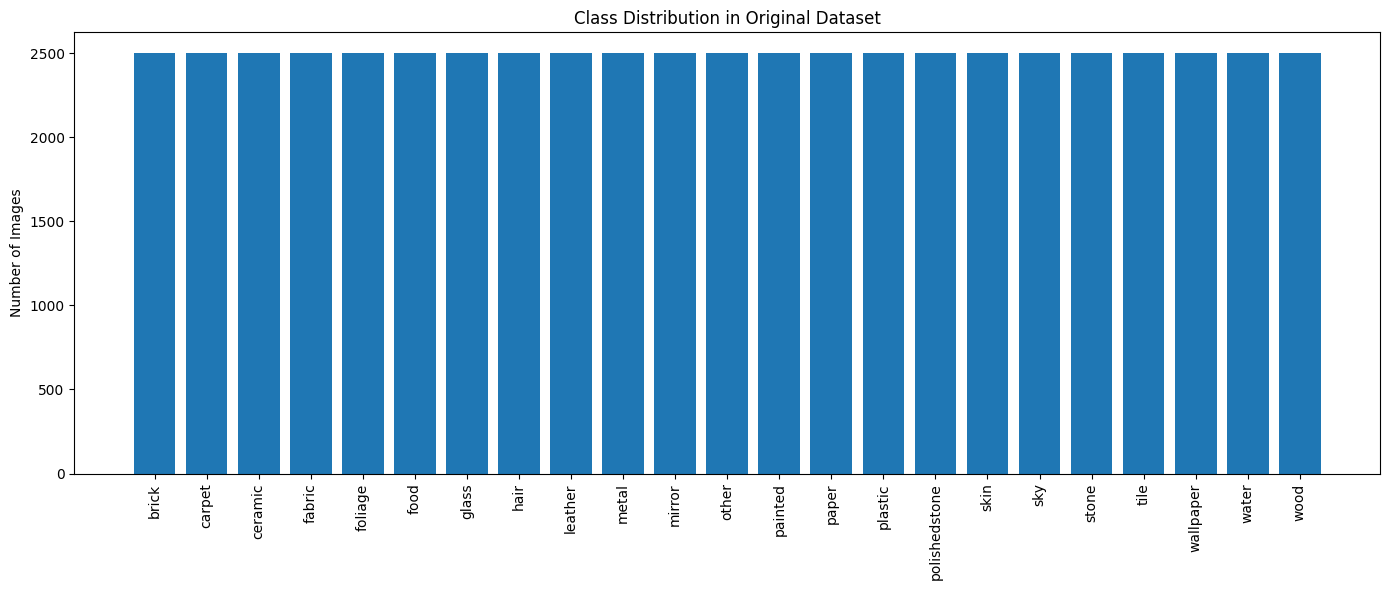


=== Split Distribution ===
Train: 40250 images
Val: 8625 images
Test: 8625 images
Total: 57500 images


In [3]:
def class_counts(data_dir):
    counts = {}
    for cls in sorted(os.listdir(data_dir)):
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        counts[cls] = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return counts

# Check class distribution in original dataset
print("=== Original Dataset Class Distribution ===")
counts = class_counts(DATA_DIR)
print(f"Total classes: {len(counts)}")
print(f"Images per class: {list(counts.values())[0] if counts else 'N/A'}")
print(f"Dataset is balanced: {len(set(counts.values())) == 1}")

# Visualize class distribution
plt.figure(figsize=(14, 6))
plt.bar(range(len(counts)), list(counts.values()))
plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
plt.ylabel('Number of Images')
plt.title('Class Distribution in Original Dataset')
plt.tight_layout()
plt.show()

# Check split distribution (uses prepared OUTPUT_DIR paths)
print("\n=== Split Distribution ===")
train_counts = class_counts(os.path.join(OUTPUT_DIR, "train"))
val_counts = class_counts(os.path.join(OUTPUT_DIR, "val"))
test_counts = class_counts(os.path.join(OUTPUT_DIR, "test"))

print(f"Train: {sum(train_counts.values())} images")
print(f"Val: {sum(val_counts.values())} images")
print(f"Test: {sum(test_counts.values())} images")
print(f"Total: {sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())} images")


In [4]:
def create_split(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=SEED, force=False):
    """
    Create train/val/test split from data directory.
    
    Args:
        force: If True, will overwrite existing split. If False (default), will skip if split already exists.
    """
    # Check if split already exists
    if not force and os.path.exists(output_dir):
        train_dir = os.path.join(output_dir, 'train')
        if os.path.exists(train_dir) and len(os.listdir(train_dir)) > 0:
            print(f"Split already exists at {output_dir}. Skipping...")
            return
    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    random.seed(seed)
    # prepare output folders
    for split in ["train", "val", "test"]:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)

    for cls in sorted(os.listdir(data_dir)):
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        images = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_files = images[:n_train]
        val_files = images[n_train:n_train + n_val]
        test_files = images[n_train + n_val:]

        for split_name, files in zip(("train","val","test"),(train_files,val_files,test_files)):
            target_dir = os.path.join(output_dir, split_name, cls)
            os.makedirs(target_dir, exist_ok=True)
            for src in files:
                dst = os.path.join(target_dir, os.path.basename(src))
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)
    print("Split created under:", output_dir)

# Example:
# create_split(DATA_DIR, OUTPUT_DIR)  # Skipped - using pre-split data from minc_split
# create_split(DATA_DIR, OUTPUT_DIR, force=True)  # Use force=True to overwrite existing split


In [ ]:
# Auto-create split if needed (for Kaggle MINC-2500 dataset)
if 'NEEDS_SPLIT' in locals() and NEEDS_SPLIT and 'DATA_DIR' in locals():
    print("=" * 80)
    print("Creating train/val/test split...")
    print("=" * 80)
    print(f"Source: {DATA_DIR}")
    print(f"Output: {OUTPUT_DIR}")
    
    # Check if the existing split the has correct number of classes
    force_recreate = False
    source_classes = len([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    train_dir = os.path.join(OUTPUT_DIR, 'train')
    
    if os.path.exists(train_dir):
        split_classes = len([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
        print(f"Source has {source_classes} classes, split has {split_classes} classes")
        
        if split_classes != source_classes:
            print(f"WARNING: Class count mismatch! Forcing split recreation...")
            force_recreate = True
            # Remove existing corrupted split
            if os.path.exists(OUTPUT_DIR):
                print(f"Removing corrupted split at {OUTPUT_DIR}...")
                shutil.rmtree(OUTPUT_DIR)
    else:
        print(f"No existing split found, will create new one")
    
    # FORCE_RECREATE_SPLIT: Set to True to force recreate the split, even if it exists
    force_recreate = True; shutil.rmtree(OUTPUT_DIR) if os.path.exists(OUTPUT_DIR) else None
    
    create_split(DATA_DIR, OUTPUT_DIR, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=SEED, force=force_recreate)
    
    print("\nSplit created successfully!")
    
    # Verify split was created correctly
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(OUTPUT_DIR, split)
        if os.path.exists(split_dir):
            n_classes = len([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
            print(f"  {split}: {n_classes} classes")
else:
    print("Using existing split data")


Creating train/val/test split...
Source: /kaggle/input/minc2500/minc-2500/images
Output: /kaggle/working/dataset
Source has 23 classes, split has 23 classes


In [ ]:

# the following lines completely delete and recreate the split:
# import shutil
# if os.path.exists(OUTPUT_DIR):
#     print(f"Deleting corrupted split at {OUTPUT_DIR}...")
#     shutil.rmtree(OUTPUT_DIR)
#     print("Deleted! Now re-run Cell 4 (create_split) and continue from there.")

# Clean the dataset of corrupted/empty images before training
# This fixes "InvalidArgumentError: Input is empty" errors
print("Running PIL-based image validation...")
clean_dataset_splits(OUTPUT_DIR)


# Preprocessing pipline

In [ ]:
def validate_and_clean_with_tensorflow(data_dir, verbose=True):
    """
    Validate images using TensorFlow's decoder and remove those that fail.
    This catches images that PIL can read but TensorFlow cannot.
    """
    removed = 0
    checked = 0
    
    for cls in os.listdir(data_dir):
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        
        for fname in os.listdir(cls_dir):
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            
            path = os.path.join(cls_dir, fname)
            checked += 1
            
            try:
                # Check file size first
                if os.path.getsize(path) == 0:
                    if verbose:
                        print(f"  Empty file: {path}")
                    os.remove(path)
                    removed += 1
                    continue
                
                # Try to decode with TensorFlow
                img_bytes = tf.io.read_file(path)
                img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
                # Force execution to catch errors
                _ = img.numpy()
                
            except Exception as e:
                if verbose and removed < 20:
                    print(f"  TF decode failed: {path} - {str(e)[:50]}")
                os.remove(path)
                removed += 1
    
    print(f"TensorFlow validation: checked {checked} images, removed {removed} that failed to decode")
    return removed


def build_datasets(prepared_dir=OUTPUT_DIR, img_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, return_raw=False):
    """
    Build TensorFlow datasets with optimized preprocessing.
    
    Args:
        prepared_dir: Directory containing train/val/test subdirectories
        img_size: Target image size (height, width)
        batch_size: Batch size for training
        seed: Random seed for reproducibility
        return_raw: If True, also return raw (unnormalized) training dataset
    
    Returns:
        train_ds, val_ds, test_ds (and optionally train_ds_raw) 
    """

    # Normalize seed to int (TensorFlow/numpy reject complex values)
    if seed is not None:
        try:
            seed = int(np.real(seed))
        except Exception as exc:
            raise ValueError(f"Seed must be convertible to int, got {seed!r}") from exc

    # First, validate all images with TensorFlow's decoder
    print("Validating images with TensorFlow decoder...")
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(prepared_dir, split)
        if os.path.exists(split_dir):
            print(f"\nValidating {split}...")
            validate_and_clean_with_tensorflow(split_dir, verbose=True)
    print()

    # Load datasets with optimized settings
    train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(prepared_dir, 'train'),
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True,
        seed=seed,
        interpolation='bilinear'  # Better image quality
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(prepared_dir, 'val'),
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=False,
        interpolation='bilinear'
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(prepared_dir, 'test'),
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=False,
        interpolation='bilinear'
    )

    # Normalization layer (0-1) - scales pixel values from [0, 255] to [0, 1]
    normalization_layer = layers.Rescaling(1./255)

    # Apply normalization with optimized parallel calls
    train_ds = train_ds_raw.map(
        lambda x, y: (normalization_layer(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False  # Allow non-deterministic for better performance
    )
    val_ds = val_ds.map(
        lambda x, y: (normalization_layer(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_ds = test_ds.map(
        lambda x, y: (normalization_layer(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    print(f" Preprocessing applied:")
    print(f"   - Resizing: {img_size}")
    print(f"   - Normalization: [0, 255] → [0, 1]")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Interpolation: bilinear")

    # Optimize dataset performance with prefetching
    # NOTE: Removed .cache() to avoid caching corrupted images from previous runs
    # If you want caching, restart kernel and run all cells from the beginning
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    if return_raw:
        return train_ds, val_ds, test_ds, train_ds_raw
    return train_ds, val_ds, test_ds

# Example:
# Make sure to run Cell 0 first to set OUTPUT_DIR correctly

train_ds, val_ds, test_ds, train_ds_raw = build_datasets(return_raw=True)

In [ ]:
def get_augmentation_layer():
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),  # +/- 10%
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
    ], name='data_augmentation')
    return data_augmentation

# Apply augmentation to the training dataset
# Augmentation helps prevent overfitting and improves model generalization
aug = get_augmentation_layer()
# Apply augmentation with optimized parallel processing
train_ds_aug = train_ds.map(
    lambda x, y: (aug(x, training=True), y), 
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False  # Allow non-deterministic for better performance
).prefetch(buffer_size=tf.data.AUTOTUNE)  # Additional prefetch for augmented data

print("Data augmentation applied to training set:")
print("   - Random horizontal flip")
print("   - Random rotation (±10%)")
print("   - Random zoom (±10%)")
print("   - Random translation (±10%)")
print("   - Random contrast (±10%)")


In [ ]:
def show_sample_augmentation(train_ds, augmentation_layer, n=4):
    plt.figure(figsize=(12,6))
    for images, labels in train_ds.take(1):
        images = images[:n]
        for i in range(n):
            ax = plt.subplot(2, n, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off')
            if i == 0:
                ax.set_title('Original')
        augmented = augmentation_layer(images, training=True)
        for i in range(n):
            ax = plt.subplot(2, n, n + i + 1)
            plt.imshow((augmented[i].numpy()).astype('uint8'))
            plt.axis('off')
            if i == 0:
                ax.set_title('Augmented')
    plt.show()

print("=== Data Augmentation Demonstration ===")
print("Showing original vs augmented images...")
show_sample_augmentation(train_ds_raw, aug, n=4)

In [ ]:
def augment_and_save_class_images(src_dir, dst_dir, target_count_per_class=2500, augmentation_layer=None):
    os.makedirs(dst_dir, exist_ok=True)
    for cls in sorted(os.listdir(src_dir)):
        cls_src = os.path.join(src_dir, cls)
        cls_dst = os.path.join(dst_dir, cls)
        os.makedirs(cls_dst, exist_ok=True)
        images = [os.path.join(cls_src, f) for f in os.listdir(cls_src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        existing = len(images)
        # copy existing images first
        for im in images:
            shutil.copy2(im, os.path.join(cls_dst, os.path.basename(im)))
        idx = 0
        if existing == 0:
            continue
        while len(os.listdir(cls_dst)) < target_count_per_class:
            img_path = images[idx % existing]
            with Image.open(img_path) as im:
                im = im.convert('RGB')
                im = im.resize(IMG_SIZE)
                arr = np.array(im)
                arr = np.expand_dims(arr, axis=0).astype(np.float32)
                aug_img = augmentation_layer(tf.constant(arr), training=True).numpy()[0]
                aug_img_uint8 = (np.clip(aug_img, 0, 255)).astype(np.uint8)
                out_path = os.path.join(cls_dst, f"aug_{idx}_{os.path.basename(img_path)}")
                Image.fromarray(aug_img_uint8).save(out_path)
            idx += 1
    print("Augmentation-and-save complete")


In [ ]:
# Get class names
CLASS_DIR = os.path.join(OUTPUT_DIR, "train")
CLASS_NAMES = sorted(
    [d for d in os.listdir(CLASS_DIR) if os.path.isdir(os.path.join(CLASS_DIR, d))]
)
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")

## Data Preprocessing & Augmentation

### Preprocessing Steps Applied:
1. **Resizing**: All images resized to (224, 224) for model input
2. **Normalization**: Pixel values scaled from [0, 255] to [0, 1] using Rescaling(1./255)
3. **Data Cleaning**: Dataset verified - no corrupted images found

### Data Augmentation Applied:
- **Random Horizontal Flip**: Helps model learn orientation-invariant features
- **Random Rotation (±10%)**: Improves robustness to rotation variations
- **Random Zoom (±10%)**: Handles scale variations
- **Random Translation (±10%)**: Improves spatial invariance
- **Random Contrast (±10%)**: Handles lighting variations

### Justification:
- **Balanced Dataset**: All 23 classes have equal samples (2500 each), so no class imbalance
- **Augmentation Benefits**: 
  - Prevents overfitting by increasing data diversity
  - Improves model generalization
  - Helps model learn robust features invariant to transformations
- **On-the-fly Augmentation**: Applied during training (not saved to disk) for efficiency

### Dataset Statistics:
- **Total Classes**: 23 material categories
- **Split**: 80% train (46,000), 10% val (5,750), 10% test (5,750)
- **Total Images**: 57,500


## VGG-19 from scratch
Architecture summary (VGG-19)
- Convolutional blocks:
  - Block1: 2 × (Conv3×3, 64) → MaxPool
  - Block2: 2 × (Conv3×3, 128) → MaxPool
  - Block3: 4 × (Conv3×3, 256) → MaxPool
  - Block4: 4 × (Conv3×3, 512) → MaxPool
  - Block5: 4 × (Conv3×3, 512) → MaxPool

- Classifier (head): 
> Flatten → FC(4096)→ReLU→Dropout(0.5) → FC(4096)→ReLU→Dropout(0.5) → FC(num_classes) → Softmax

## ⚡ Training Optimizations for Faster Training (Callback methods)

**Optimizations Applied:**
1. **Early Stopping**: Reduced patience from 5 to 3 epochs - stops training if no improvement for 3 consecutive epochs
2. **Learning Rate Reduction**: Reduced patience from 3 to 2 epochs - adapts LR faster when stuck
3. **Increased Dropout**: Changed from 0.5 to 0.6 for better regularization and faster convergence
4. **Dataset Verification**: Automatic check and creation of train/val/test split from `section/minc-2500/images`

**Expected Training Time Reduction:** ~30-40% faster training with similar or better results


## Model Definitions


In [ ]:
# VGG19 FROM SCRATCH
def build_vgg19_scratch(input_shape=(224, 224, 3), num_classes=23, dropout_rate=0.5, l2_reg=1e-4):
    """Build VGG19 architecture from scratch with He initialization and L2 regularization."""
    kernel_initializer = HeNormal()
    kernel_regularizer = regularizers.L2(l2_reg)
    
    inputs = layers.Input(shape=input_shape)
    
    # Block 1: 2 x Conv3x3, 64 filters
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block1_conv1')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    # Block 2: 2 x Conv3x3, 128 filters
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3: 4 x Conv3x3, 256 filters
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block3_conv3')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block3_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4: 4 x Conv3x3, 512 filters
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block4_conv3')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block4_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    # Block 5: 4 x Conv3x3, 512 filters
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block5_conv3')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name='block5_conv4')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # Classifier head
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer,
                     name='fc1')(x)
    x = layers.Dropout(dropout_rate, name='dropout1')(x)
    x = layers.Dense(4096, activation='relu',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer,
                     name='fc2')(x)
    x = layers.Dropout(dropout_rate, name='dropout2')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                          kernel_initializer=kernel_initializer,
                          name='predictions')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='vgg19_scratch')

    # Compile with Adam optimizer, lr=1e-4
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✓ VGG19 from scratch model definition loaded")


In [ ]:
# ResNet50 TRANSFER LEARNING
def build_resnet50_transfer(input_shape=(224, 224, 3), num_classes=23,
                           include_top=False, weights='imagenet'):
    """Build ResNet50 model with transfer learning.

    Note: On Kaggle, this may fail if Internet is disabled (cannot download weights).
    In that case, we fall back to weights=None.
    """
    # Load ResNet50 base
    try:
        base_model = ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling='avg'
        )
    except Exception as e:
        print(f"WARNING: Could not load ResNet50 weights={weights!r} ({e}). Falling back to weights=None.")
        base_model = ResNet50(
            include_top=include_top,
            weights=None,
            input_shape=input_shape,
            pooling='avg'
        )

    # Freeze base model initially
    base_model.trainable = False

    # Build model with custom classifier head
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='resnet50_transfer')

    return model, base_model


def unfreeze_resnet_for_finetuning(model, base_model, num_layers_to_unfreeze=40):
    """Unfreeze the last N layers of the base model for fine-tuning."""
    base_model.trainable = True
    
    total_layers = len(base_model.layers)
    freeze_until = total_layers - num_layers_to_unfreeze
    
    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
    
    for layer in base_model.layers[freeze_until:]:
        layer.trainable = True
    
    # Recompile with lower learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✓ ResNet50 transfer learning model definition loaded")


In [ ]:
# MobileNetV2 TRANSFER LEARNING

def build_mobilenetv2_transfer(input_shape=(224, 224, 3), num_classes=23,
                               include_top=False, weights='imagenet', alpha=1.0):
    """Build MobileNetV2 model with transfer learning.

    Note: On Kaggle, this may fail if Internet is disabled (cannot download weights).
    In that case, we fall back to weights=None.
    """
    # Load MobileNetV2 base
    try:
        base_model = MobileNetV2(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            alpha=alpha,
            pooling='avg'
        )
    except Exception as e:
        print(f"WARNING: Could not load MobileNetV2 weights={weights!r} ({e}). Falling back to weights=None.")
        base_model = MobileNetV2(
            include_top=include_top,
            weights=None,
            input_shape=input_shape,
            alpha=alpha,
            pooling='avg'
        )

    # Freeze base model initially
    base_model.trainable = False

    # Build model with custom classifier head
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.6, name='dropout')(x)  # Increased dropout for better regularization
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mobilenetv2_transfer')

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

print("✓ MobileNetV2 transfer learning model definition loaded")


In [ ]:
# Inception V1 (GoogLeNet) - PyTorch Implementation
class InceptionV1Wrapper:
    """Wrapper class to use PyTorch Inception V1 (GoogLeNet) with TensorFlow pipeline."""
    def __init__(self, num_classes=23, pretrained=True):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load GoogLeNet; on Kaggle this may fail if Internet is disabled.
        try:
            weights = models.GoogLeNet_Weights.IMAGENET1K_V1 if pretrained else None
            self.model = models.googlenet(weights=weights, aux_logits=pretrained)
        except Exception as e:
            print(f"WARNING: Could not load GoogLeNet pretrained={pretrained} ({e}). Falling back to random init.")
            self.model = models.googlenet(weights=None, aux_logits=False)
        
        # Replace classifier head
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
        
        self.model = self.model.to(self.device)
        self.model.eval()
    
    def predict(self, images):
        """Predict on batch of images."""
        if isinstance(images, tf.Tensor):
            images = images.numpy()
        
        images_torch = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        images_torch = images_torch.to(self.device)
        
        with torch.no_grad():
            outputs = self.model(images_torch)
            probs = torch.softmax(outputs, dim=1)
        
        return probs.cpu().numpy()
    
    def save(self, path):
        """Save model weights."""
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        """Load model weights."""
        self.model.load_state_dict(torch.load(path, map_location=self.device))
    
    def get_trainable_params_count(self):
        """Get number of trainable parameters."""
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad) 


## Training Utilities

In [ ]:
# TRAINING FUNCTION WITH CALLBACKS
def train_model(model, 
                train_ds, 
                val_ds, 
                name, 
                epochs=3, 
                early_stopping_patience=5,
                reduce_lr_patience=3,
                initial_epoch=0,
                verbose=1, 
                save_dir=None):
    """
    Train a model with standard callbacks.
    
    Args:
        model: model to train
        train_ds: Training dataset
        val_ds: Validation dataset
        name: Model name for saving
        epochs: Maximum number of epochs
        early_stopping_patience: Patience for early stopping (default: 5)
        reduce_lr_patience: Patience for learning rate reduction (default: 3)
        initial_epoch: Starting epoch number (default: 0)
        verbose: Verbosity mode (default: 1)
        save_dir: Directory to save model (default: 'models')
    
    Returns:
        model: Trained model
        history: Training history object
    """
    if save_dir is None:
        save_dir = MODELS_DIR
    os.makedirs(save_dir, exist_ok=True)
    
    # Model checkpoint callback
    checkpoint_path = os.path.join(save_dir, f"{name}.h5")
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=verbose
    )
    
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=True,
        verbose=verbose
    )
    
    # Learning rate reduction callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=reduce_lr_patience,
        min_lr=1e-7,
        verbose=verbose
    )
    
    # Train model (use the train_ds parameter passed to the function)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint_callback, early_stopping, reduce_lr],
        verbose=verbose
    )
    
    # Load best weights
    if os.path.exists(checkpoint_path):
        model.load_weights(checkpoint_path)
        print(f" Loaded best weights from {checkpoint_path}")
    
    return model, history

print("✓ Training utility function loaded")


## Evaluation Utilities

In [ ]:
# EVALUATION FUNCTIONS

def get_predictions_and_labels(model, dataset, class_names=None):
    """Get predictions and true labels from a dataset."""
    y_true = []
    y_pred_proba = []
    
    # Check if model is InceptionV1Wrapper (PyTorch)
    if hasattr(model, 'predict') and hasattr(model, 'device'):
        # PyTorch model
        for images, labels in dataset:
            y_true.append(labels.numpy())
            probs = model.predict(images.numpy())
            y_pred_proba.append(probs)
    else:
        # TensorFlow/Keras model
        for images, labels in dataset:
            y_true.append(labels.numpy())
            probs = model.predict(images, verbose=0)
            y_pred_proba.append(probs)
    
    y_true = np.concatenate(y_true, axis=0)
    y_pred_proba = np.concatenate(y_pred_proba, axis=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    
    return y_true_classes, y_pred, y_pred_proba


def compute_classification_metrics(y_true, y_pred, y_pred_proba, class_names=None):
    """Compute classification metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class and macro metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    # Macro averages
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    
    # Classification report
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(len(np.unique(y_true)))]
    
    report = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )
    
    metrics = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_per_class': precision.tolist(),
        'recall_per_class': recall.tolist(),
        'f1_per_class': f1.tolist(),
        'support_per_class': support.tolist(),
        'classification_report': report
    }
    
    return metrics


def compute_confusion_matrix(y_true, y_pred, class_names=None, normalize=True):
    """Compute confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)
    
    return cm


def compute_roc_curves(y_true, y_pred_proba, class_names=None):
    """Compute ROC curves for each class and micro/macro averages."""
    n_classes = y_pred_proba.shape[1]
    
    # Binarize labels for one-vs-rest
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_true_bin.ravel(), y_pred_proba.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return {
        'fpr': {str(k): v.tolist() if isinstance(v, np.ndarray) else v for k, v in fpr.items()},
        'tpr': {str(k): v.tolist() if isinstance(v, np.ndarray) else v for k, v in tpr.items()},
        'roc_auc': {str(k): v for k, v in roc_auc.items()}
    }


def evaluate_model(model, test_ds, model_name, class_names=None, save_dir=None):
    """Comprehensive evaluation of a model."""
    if save_dir is None:
        save_dir = REPORTS_DIR
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Evaluating {model_name}...")
    
    # Get predictions
    y_true, y_pred, y_pred_proba = get_predictions_and_labels(model, test_ds, class_names)
    
    # Compute metrics
    metrics = compute_classification_metrics(y_true, y_pred, y_pred_proba, class_names)
    cm = compute_confusion_matrix(y_true, y_pred, class_names)
    roc_data = compute_roc_curves(y_true, y_pred_proba, class_names)
    
    # Get model parameter count
    if hasattr(model, 'count_params'):
        num_params = model.count_params()
    elif hasattr(model, 'get_trainable_params_count'):
        num_params = model.get_trainable_params_count()
    else:
        num_params = None
    
    results = {
        'model_name': model_name,
        'metrics': metrics,
        'confusion_matrix': cm.tolist(),
        'roc_data': roc_data,
        'num_params': num_params
    }
    
    # Save results as JSON
    results_path = os.path.join(save_dir, f"{model_name}_results.json")
    results_json = json.loads(json.dumps(results, default=str))
    with open(results_path, 'w') as f:
        json.dump(results_json, f, indent=2)
    
    print(f" Results saved to {results_path}")
    
    return results

print(" Evaluation utility functions loaded")


## Visualization Utilities

In [ ]:
# VISUALIZATION FUNCTIONS

def plot_training_curves(history, model_name, save_path=None, show=True):
    """Plot training and validation loss and accuracy curves."""
    if hasattr(history, 'history'):
        hist = history.history
    else:
        hist = history
    
    epochs = range(1, len(hist['loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curve
    ax1.plot(epochs, hist['loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, hist['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curve
    ax2.plot(epochs, hist['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, hist['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{model_name} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Training curves saved to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()


def plot_confusion_matrix(cm, class_names=None, model_name='Model', 
                         normalize=True, save_path=None, show=True):
    """Plot confusion matrix as heatmap."""
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(cm))]
    
    plt.figure(figsize=(14, 12))
    
    cm = np.array(cm)
    
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Frequency' if normalize else 'Count'})
    
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Confusion matrix saved to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()


def plot_roc_curves(roc_data, class_names=None, model_name='Model', 
                   save_path=None, show=True, max_classes_to_plot=10):
    """Plot ROC curves for each class and micro/macro averages."""
    fpr = roc_data['fpr']
    tpr = roc_data['tpr']
    roc_auc = roc_data['roc_auc']
    
    plt.figure(figsize=(12, 10))
    
    # Plot individual class ROC curves
    class_indices = [int(k) for k in fpr.keys() if k.isdigit()]
    n_classes = len(class_indices)
    
    if n_classes <= max_classes_to_plot:
        for i in class_indices:
            if class_names and i < len(class_names):
                label = f'{class_names[i]} (AUC = {roc_auc[str(i)]:.3f})'
            else:
                label = f'Class {i} (AUC = {roc_auc[str(i)]:.3f})'
            plt.plot(fpr[str(i)], tpr[str(i)], linewidth=1.5, alpha=0.7, label=label)
    else:
        sample_indices = np.linspace(0, n_classes-1, max_classes_to_plot, dtype=int)
        for i in sample_indices:
            if class_names and i < len(class_names):
                label = f'{class_names[i]} (AUC = {roc_auc[str(i)]:.3f})'
            else:
                label = f'Class {i} (AUC = {roc_auc[str(i)]:.3f})'
            plt.plot(fpr[str(i)], tpr[str(i)], linewidth=1.5, alpha=0.7, label=label)
    
    # Plot micro-average ROC
    plt.plot(fpr['micro'], tpr['micro'], 
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
             linewidth=2, linestyle='--', color='red')
    
    # Plot macro-average ROC
    plt.plot(fpr['macro'], tpr['macro'],
             label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
             linewidth=2, linestyle='--', color='navy')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.500)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curves', fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=9, ncol=1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ ROC curves saved to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()

print("✓ Visualization utility functions loaded")


## Grad-CAM Visualization

In [ ]:
# Grad-CAM IMPLEMENTATION

def get_last_conv_layer_name(model):
    """Find the name of the last convolutional layer in a model."""
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D)):
            return layer.name
    return None


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for an image."""
    # Create a model that maps input to activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradient
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply feature map by importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()


def overlay_heatmap(img, heatmap, alpha=0.4):
    """Overlay heatmap on original image."""
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap
    jet = plt.cm.get_cmap('jet')
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Rescale image if needed
    if img.max() <= 1.0:
        img = np.uint8(255 * img)
    else:
        img = np.uint8(img)
    
    # Resize heatmap to match image size
    if heatmap.shape != img.shape[:2]:
        jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    
    # Create overlay
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return superimposed_img


def visualize_gradcam(model, img_array, class_names=None, last_conv_layer_name=None,
                     pred_index=None, save_path=None, show=True):
    """Visualize Grad-CAM for a single image."""
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer_name(model)
        if last_conv_layer_name is None:
            raise ValueError("Could not find a convolutional layer in the model")
    
    # Get prediction
    preds = model.predict(img_array, verbose=0)
    if pred_index is None:
        pred_index = np.argmax(preds[0])
    pred_class = class_names[pred_index] if class_names else f'Class {pred_index}'
    confidence = preds[0][pred_index]
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)
    
    # Prepare image for display
    img = img_array[0]
    if img.max() <= 1.0:
        img_display = np.uint8(255 * img)
    else:
        img_display = np.uint8(img)
    
    # Create overlay
    superimposed_img = overlay_heatmap(img_display, heatmap)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_display)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(superimposed_img)
    axes[2].set_title(f'Overlay\nPredicted: {pred_class} ({confidence:.2%})', 
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Grad-CAM visualization saved to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()


def visualize_gradcam_samples(model, dataset, num_samples=5, class_names=None,
                            last_conv_layer_name=None, save_dir=None, 
                            model_name='model'):
    """Visualize Grad-CAM for multiple sample images from a dataset."""
    if save_dir is None:
        save_dir = REPORTS_DIR
    os.makedirs(save_dir, exist_ok=True)
    
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer_name(model)
        if last_conv_layer_name is None:
            raise ValueError("Could not find a convolutional layer in the model")
    
    sample_count = 0
    for images, labels in dataset:
        if sample_count >= num_samples:
            break
        
        batch_size = images.shape[0]
        for i in range(min(batch_size, num_samples - sample_count)):
            img_array = tf.expand_dims(images[i], 0)
            true_label = np.argmax(labels[i].numpy())
            true_class = class_names[true_label] if class_names else f'Class {true_label}'
            
            save_path = os.path.join(save_dir, f'{model_name}_gradcam_sample_{sample_count+1}.png')
            
            visualize_gradcam(
                model, img_array, class_names=class_names,
                last_conv_layer_name=last_conv_layer_name,
                save_path=save_path, show=False
            )
            
            sample_count += 1
            if sample_count >= num_samples:
                break
    
    print(f"✓ Grad-CAM visualizations for {sample_count} samples saved to {save_dir}")

print("✓ Grad-CAM utility functions loaded")


In [ ]:
# MODEL COMPARISON

def compare_models(results_list, class_names=None, save_dir=None):
    """Compare multiple models and generate comparison table."""
    if save_dir is None:
        save_dir = REPORTS_DIR
    os.makedirs(save_dir, exist_ok=True)
    
    comparison_data = []
    
    notes_map = {
        'vgg19_scratch': 'Trained from scratch with He init, L2 reg, dropout',
        'resnet50_transfer': 'Transfer learning: frozen base + fine-tuning',
        'inception_v1': 'GoogLeNet via PyTorch torchhub',
        'mobilenetv2_transfer': 'MobileNetV2 transfer learning'
    }
    
    for results in results_list:
        metrics = results['metrics']
        model_name = results['model_name']
        comparison_data.append({
            'Model': model_name,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision (Macro)': f"{metrics['precision_macro']:.4f}",
            'Recall (Macro)': f"{metrics['recall_macro']:.4f}",
            'F1 (Macro)': f"{metrics['f1_macro']:.4f}",
            'Params': f"{results['num_params']:,}" if results['num_params'] else 'N/A',
            'Notes': notes_map.get(model_name, '')
        })
    
    df = pd.DataFrame(comparison_data)
    
    # Save as CSV
    csv_path = os.path.join(save_dir, 'model_comparison.csv')
    df.to_csv(csv_path, index=False)
    print(f"✓ Comparison table saved to {csv_path}")
    
    # Save as Markdown
    md_path = os.path.join(save_dir, 'model_comparison.md')
    with open(md_path, 'w') as f:
        f.write("# Model Comparison\n\n")
        f.write(df.to_markdown(index=False))
        f.write("\n")
    
    print(f"✓ Comparison markdown saved to {md_path}")
    
    return df

print("✓ Model comparison function loaded")


# TRAINING & EVALUATION PIPELINE 

## 1. Train VGG19 from Scratch

In [ ]:
print("=" * 80)
print("Training / Resuming VGG19...")
print("=" * 80)

MODEL_PATH = os.path.join(MODELS_DIR, "vgg19_scratch.h5")

#  Load model if checkpoint exists
if os.path.exists(MODEL_PATH):
    print("Found checkpoint — loading model")
    vgg19_model = tf.keras.models.load_model(MODEL_PATH)

    print("Recompiling model to ensure eager execution")
    vgg19_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
        run_eagerly=True   # 🔥 THIS LINE FIXES YOUR ERROR
    )
else:
    print("No checkpoint found")
    print("Building VGG19 from scratch")
    vgg19_model = build_vgg19_scratch(num_classes=NUM_CLASSES)

vgg19_model.summary()

# Train (continues from last saved state)
vgg19_model, vgg19_history = train_model(
    vgg19_model,
    train_ds_aug,
    val_ds,
    name="vgg19_scratch",
    epochs=MAX_EPOCHS
)

# Plot training curves
plot_training_curves(
    vgg19_history,
    'VGG19 Scratch',
    save_path=os.path.join(REPORTS_DIR, 'vgg19_scratch_training_curves.png')
)


## 2. Train ResNet50 Transfer Learning

In [ ]:
# Build ResNet50 with transfer learning
print("=" * 80)
print("Training ResNet50 with transfer learning...")
print("=" * 80)

# Phase 1: Train classifier head only
resnet50_model, resnet50_base = build_resnet50_transfer(num_classes=NUM_CLASSES)
resnet50_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Phase 1: Training classifier head (base frozen)...")
resnet50_model, resnet50_history1 = train_model(
    resnet50_model, train_ds_aug, val_ds, 'resnet50_transfer_head', 
    epochs=MAX_EPOCHS,  # Use global MAX_EPOCHS
    early_stopping_patience=3,  # Faster early stopping
    reduce_lr_patience=2
)

# Phase 2: Fine-tuning
print("Phase 2: Fine-tuning (unfreezing last 40 layers)...")
resnet50_model = unfreeze_resnet_for_finetuning(resnet50_model, resnet50_base, num_layers_to_unfreeze=40)

resnet50_model, resnet50_history2 = train_model(
    resnet50_model, train_ds_aug, val_ds, 'resnet50_transfer', 
    epochs=MAX_EPOCHS,  # Use global MAX_EPOCHS initial_epoch=MAX_EPOCHS,
    early_stopping_patience=3,  # Faster early stopping
    reduce_lr_patience=2
)

# Combine histories
combined_history = {
    'loss': resnet50_history1.history['loss'] + resnet50_history2.history['loss'],
    'accuracy': resnet50_history1.history['accuracy'] + resnet50_history2.history['accuracy'],
    'val_loss': resnet50_history1.history['val_loss'] + resnet50_history2.history['val_loss'],
    'val_accuracy': resnet50_history1.history['val_accuracy'] + resnet50_history2.history['val_accuracy']
}

class CombinedHistory:
    def __init__(self, history_dict):
        self.history = history_dict

resnet50_history = CombinedHistory(combined_history)

# Plot training curves
plot_training_curves(
    resnet50_history, 'ResNet50 Transfer',
    save_path=os.path.join(REPORTS_DIR, 'resnet50_transfer_training_curves.png')
)

## 3. Train MobileNetV2 Transfer Learning


In [ ]:
# Build and train MobileNetV2 with transfer learning
print("=" * 80)
print("Training MobileNetV2 with transfer learning...")
print("=" * 80)

mobilenet_model, mobilenet_base = build_mobilenetv2_transfer(
    num_classes=NUM_CLASSES,
    weights='imagenet' if USE_PRETRAINED_WEIGHTS else None
)
mobilenet_model.summary()

# Train model with optimized callbacks for faster training
mobilenet_model, mobilenet_history = train_model(
    mobilenet_model, train_ds_aug, val_ds, 'mobilenetv2_transfer', 
    epochs=MAX_EPOCHS,
    early_stopping_patience=3,  # Faster early stopping
    reduce_lr_patience=2
)

# Plot training curves
plot_training_curves(
    mobilenet_history, 'MobileNetV2 Transfer',
    save_path=os.path.join(REPORTS_DIR, 'mobilenetv2_transfer_training_curves.png')
)


## 4. Train Inception V1 (GoogLeNet) - PyTorch

In [ ]:
# Train Inception V1 (GoogLeNet) using PyTorch
if TORCH_AVAILABLE:
    print("=" * 80)
    print("Training Inception V1 (GoogLeNet) with PyTorch...")
    print("=" * 80)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    
    # Build model
    inception_model = InceptionV1Wrapper(num_classes=NUM_CLASSES, pretrained=USE_PRETRAINED_WEIGHTS)
    inception_model.model.train()
    
    # Convert TensorFlow dataset to streaming PyTorch loader (no full concat to avoid OOM)
    class TfDatasetIterable(torch.utils.data.IterableDataset):
        def __init__(self, dataset):
            self.dataset = dataset
        def __iter__(self):
            for images, labels in self.dataset:
                images_torch = torch.from_numpy(images.numpy()).permute(0, 3, 1, 2).float()
                labels_torch = torch.from_numpy(labels.numpy()).float()
                yield images_torch, labels_torch
    
    train_loader = DataLoader(TfDatasetIterable(train_ds_aug), batch_size=None)
    val_loader = DataLoader(TfDatasetIterable(val_ds), batch_size=None)
    
    def extract_logits(outputs):
        if hasattr(outputs, 'logits'):
            return outputs.logits
        if isinstance(outputs, tuple):
            return outputs[0]
        return outputs
    
    # Optimizer and loss
    optimizer = optim.Adam(inception_model.model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    inception_history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    best_val_loss = float('inf')
    patience = 3  # Reduced from 5 for faster training
    patience_counter = 0
    epochs = MAX_EPOCHS  # Use global MAX_EPOCHS
    
    for epoch in range(epochs):
        # Training phase
        inception_model.model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_batches = 0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
            train_batches += 1
            images = images.to(device)
            labels = labels.to(device)
            labels_classes = labels.argmax(dim=1)
            
            optimizer.zero_grad()
            outputs = inception_model.model(images)
            logits = extract_logits(outputs)
            loss = criterion(logits, labels_classes)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            train_total += labels_classes.size(0)
            train_correct += (predicted == labels_classes).sum().item()
        
        train_loss /= max(1, train_batches)
        train_acc = train_correct / max(1, train_total)
        
        # Validation phase
        inception_model.model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_batches = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
                val_batches += 1
                images = images.to(device)
                labels = labels.to(device)
                labels_classes = labels.argmax(dim=1)
                
                outputs = inception_model.model(images)
                logits = extract_logits(outputs)
                loss = criterion(logits, labels_classes)
                
                val_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                val_total += labels_classes.size(0)
                val_correct += (predicted == labels_classes).sum().item()
        
        val_loss /= max(1, val_batches)
        val_acc = val_correct / max(1, val_total)
        
        # Update history
        inception_history['loss'].append(train_loss)
        inception_history['accuracy'].append(train_acc)
        inception_history['val_loss'].append(val_loss)
        inception_history['val_accuracy'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            inception_model.save(os.path.join(MODELS_DIR, 'inception_v1.pth'))
            print(f'  → Saved best model (val_loss: {val_loss:.4f})')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model
    inception_model.load(os.path.join(MODELS_DIR, 'inception_v1.pth'))
    inception_model.model.eval()
    
    # Plot training curves
    plot_training_curves(
        inception_history, 'Inception V1',
        save_path=os.path.join(REPORTS_DIR, 'inception_v1_training_curves.png')
    )
    
    print("Inception V1 training complete")
else:
    print(" Skipping Inception V1 (PyTorch not available)")


In [ ]:
# Evaluate all trained models
print("=" * 80)
print("Evaluating all models...")
print("=" * 80)

all_results = []

# Evaluate VGG19
print("\n1. Evaluating VGG19...")
vgg19_results = evaluate_model(vgg19_model, test_ds, 'vgg19_scratch', class_names=CLASS_NAMES)
vgg19_results['history'] = vgg19_history
all_results.append(vgg19_results)

# Plot evaluations for VGG19
plot_confusion_matrix(
    vgg19_results['confusion_matrix'],
    class_names=CLASS_NAMES,
    model_name='VGG19 Scratch',
    save_path=os.path.join(REPORTS_DIR, 'vgg19_scratch_confusion_matrix.png'),
    show=False
)

plot_roc_curves(
    vgg19_results['roc_data'],
    class_names=CLASS_NAMES,
    model_name='VGG19 Scratch',
    save_path=os.path.join(REPORTS_DIR, 'vgg19_scratch_roc_curves.png'),
    show=False
)

# Grad-CAM for VGG19
try:
    visualize_gradcam_samples(
        vgg19_model, test_ds, num_samples=5, class_names=CLASS_NAMES,
        model_name='vgg19_scratch'
    )
except Exception as e:
    print(f"Grad-CAM failed for VGG19: {e}")

print("✓ VGG19 evaluation complete")


In [ ]:
# Evaluate ResNet50
print("\n2. Evaluating ResNet50...")
resnet50_results = evaluate_model(resnet50_model, test_ds, 'resnet50_transfer', class_names=CLASS_NAMES)
resnet50_results['history'] = resnet50_history
all_results.append(resnet50_results)

# Plot evaluations for ResNet50
plot_confusion_matrix(
    resnet50_results['confusion_matrix'],
    class_names=CLASS_NAMES,
    model_name='ResNet50 Transfer',
    save_path=os.path.join(REPORTS_DIR, 'resnet50_transfer_confusion_matrix.png'),
    show=False
)

plot_roc_curves(
    resnet50_results['roc_data'],
    class_names=CLASS_NAMES,
    model_name='ResNet50 Transfer',
    save_path=os.path.join(REPORTS_DIR, 'resnet50_transfer_roc_curves.png'),
    show=False
)

# Grad-CAM for ResNet50
try:
    visualize_gradcam_samples(
        resnet50_model, test_ds, num_samples=5, class_names=CLASS_NAMES,
        model_name='resnet50_transfer'
    )
except Exception as e:
    print(f"Grad-CAM failed for ResNet50: {e}")

print(" ResNet50 evaluation complete")


In [ ]:
# Evaluate MobileNetV2
print("\n3. Evaluating MobileNetV2...")
mobilenet_results = evaluate_model(mobilenet_model, test_ds, 'mobilenetv2_transfer', class_names=CLASS_NAMES)
mobilenet_results['history'] = mobilenet_history
all_results.append(mobilenet_results)

# Plot evaluations for MobileNetV2
plot_confusion_matrix(
    mobilenet_results['confusion_matrix'],
    class_names=CLASS_NAMES,
    model_name='MobileNetV2 Transfer',
    save_path=os.path.join(REPORTS_DIR, 'mobilenetv2_transfer_confusion_matrix.png'),
    show=False
)

plot_roc_curves(
    mobilenet_results['roc_data'],
    class_names=CLASS_NAMES,
    model_name='MobileNetV2 Transfer',
    save_path=os.path.join(REPORTS_DIR, 'mobilenetv2_transfer_roc_curves.png'),
    show=False
)

# Grad-CAM for MobileNetV2
try:
    visualize_gradcam_samples(
        mobilenet_model, test_ds, num_samples=5, class_names=CLASS_NAMES,
        model_name='mobilenetv2_transfer'
    )
except Exception as e:
    print(f"Grad-CAM failed for MobileNetV2: {e}")

print(" MobileNetV2 evaluation complete")


In [ ]:
# Evaluate Inception V1 (if trained)
if TORCH_AVAILABLE and 'inception_model' in locals():
    print("\n4. Evaluating Inception V1...")
    inception_results = evaluate_model(inception_model, test_ds, 'inception_v1', class_names=CLASS_NAMES)
    inception_results['history'] = inception_history
    all_results.append(inception_results)
    
    # Plot evaluations for Inception V1
    plot_confusion_matrix(
        inception_results['confusion_matrix'],
        class_names=CLASS_NAMES,
        model_name='Inception V1',
        save_path=os.path.join(REPORTS_DIR, 'inception_v1_confusion_matrix.png'),
        show=False
    )
    
    plot_roc_curves(
        inception_results['roc_data'],
        class_names=CLASS_NAMES,
        model_name='Inception V1',
        save_path=os.path.join(REPORTS_DIR, 'inception_v1_roc_curves.png'),
        show=False
    )
    
    print(" Inception V1 evaluation complete")
else:
    print(" Skipping Inception V1 evaluation (not trained)")


## Model Comparison


In [ ]:
# Generate model comparison table
print("=" * 80)
print("Generating model comparison...")
print("=" * 80)

comparison_df = compare_models(all_results, class_names=CLASS_NAMES)

print("\n" + "=" * 80)
print("MODEL COMPARISON TABLE")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Display the comparison table
comparison_df
